In [121]:
import pandas as pd
import numpy as np
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
# from dash import Dash, dcc, html

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# Data Cleaning

In [3]:
# loading in data
bonds10_d = pd.read_csv('data/TVC_US10Y_1D.csv') # '/' for MacOS, '\' for Windows
qqq = pd.read_csv('data/QQQ_1D_popular.csv')

# renaming columns 
to_rename = ['EMA', 'EMA.1', 'EMA.2', 'EMA.3', 'MA', 'MA.1', 'MA.2', 'MA.3',
            'Basis', 'Upper', 'Lower',
            'Histogram', 'Signal',
            '%K', '%D',
            'OnBalanceVolume',
            'Accumulation/Distribution',
            'DI+', 'DI-',
            'Aroon Up', 'Aroon Down']

new_name = ['20_ema', '50_ema', '100_ema', '200_ema', '20_sma', '50_sma', '100_sma', '200_sma',
            'bb_basis', 'bb_upper', 'bb_lower',
           'macd_hist', 'macd_signal',
           'stoch_%K', 'stoch_%D',
           'OBV',
           'A/D',
           'adx_DI+', 'adx_DI-', 
           'aroon_up', 'aroon_down']

qqq = qqq.drop(columns = ['Upper Bollinger Band','Lower Bollinger Band', 'Regular Bullish', 'Regular Bullish Label','Regular Bearish', 'Regular Bearish Label'])
qqq.rename(columns = dict(zip(to_rename, new_name)), inplace = True)
bonds10_d.rename(columns = {'time':'bonds_time', 'open':'bonds_open', 'high':'bonds_high', 'low':'bonds_low', 'close': 'bonds_close'}, inplace = True)

# converting to datetime
qqq.time = pd.to_datetime(qqq.time)
bonds10_d.bonds_time = pd.to_datetime(bonds10_d.bonds_time)

# joining the 10Y bonds data with QQQ data
qqq = pd.merge(qqq, bonds10_d, left_on = 'time', right_on = 'bonds_time')
qqq

time       open        high        low     close      20_ema  \
0    1999-03-10   51.12500   51.156250   50.28125   51.0625         NaN   
1    1999-03-11   51.43750   51.734375   50.31250   51.3125         NaN   
2    1999-03-12   51.12500   51.156250   49.65625   50.0625         NaN   
3    1999-03-16   51.71875   52.156250   51.15625   51.9375         NaN   
4    1999-03-17   51.93750   52.000000   51.40625   51.5625         NaN   
...         ...        ...         ...        ...       ...         ...   
5559 2024-04-18  426.49000  428.240000  422.83000  423.4100  398.709452   
5560 2024-04-19  422.22000  422.750000  413.07000  414.6500  398.868064   
5561 2024-04-22  417.31000  421.180000  413.94000  418.8200  399.066591   
5562 2024-04-23  420.77000  426.280000  418.87150  425.0700  399.325331   
5563 2024-04-24  428.20000  429.730000  424.20000  426.5100  399.595825   

          50_ema     100_ema     200_ema     20_sma  ...     adx_DI+  \
0            NaN         NaN         NaN        NaN  ...  100.000000   
1            NaN         NaN         NaN        NaN  ...   98.275390   
2            NaN         NaN         NaN        NaN  ...   94.818537   
3            NaN         NaN         NaN        NaN  ...   91.490889   
4            NaN         NaN         NaN        NaN  ...   90.154534   
...          ...         ...         ...        ...  ...         ...   
5559  421.574777  433.896839  436.434436  395.91020  ...   15.691033   
5560  421.437652  433.142061  434.359728  396.13205  ...   13.955596   
5561  421.385818  432.580412  432.879754  396.38885  ...   12.881310   
5562  421.458772  432.285886  432.135968  396.68300  ...   17.247687   
5563  421.558796  432.059381  431.600161  396.98375  ...   19.915916   

        adx_DI-        ADX   aroon_up  aroon_down  bonds_time  bonds_open  \
0      0.000000        NaN        NaN         NaN  1999-03-10       5.172   
1      0.000000        NaN        NaN         NaN  1999-03-11       5.201   
2      1.393733        NaN        NaN         NaN  1999-03-12       5.197   
3      1.311734        NaN        NaN         NaN  1999-03-16       5.155   
4      1.292574        NaN        NaN         NaN  1999-03-17       5.109   
...         ...        ...        ...         ...         ...         ...   
5559  27.872405  10.537848   7.142857  100.000000  2024-04-18       4.591   
5560  35.229366  12.700272   0.000000  100.000000  2024-04-19       4.637   
5561  32.517449  15.698155  14.285714   92.857143  2024-04-22       4.643   
5562  29.958418  17.239678   7.142857   85.714286  2024-04-23       4.611   
5563  28.187546  18.132934   0.000000   78.571429  2024-04-24       4.605   

      bonds_high  bonds_low  bonds_close  
0          5.172      5.172        5.172  
1          5.201      5.201        5.201  
2          5.197      5.197        5.197  
3          5.155      5.155        5.155  
4          5.109      5.109        5.109  
...          ...        ...          ...  
5559       4.651      4.561        4.635  
5560       4.637      4.496        4.623  
5561       4.668      4.608        4.611  
5562       4.652      4.570        4.602  
5563       4.669      4.602        4.646  

[5564 rows x 36 columns]

In [5]:
print(qqq[pd.isnull(qqq).any(axis = 1)])
# For QQQ, null values for technicals from 3/10/1999 --> 12/20/1999, so roughly 1 year of data (~200 entries)
# Will drop these columns

qqq = qqq.dropna()

          time      open       high        low     close  20_ema     50_ema  \
0   1999-03-10  51.12500  51.156250  50.281250  51.06250     NaN        NaN   
1   1999-03-11  51.43750  51.734375  50.312500  51.31250     NaN        NaN   
2   1999-03-12  51.12500  51.156250  49.656250  50.06250     NaN        NaN   
3   1999-03-16  51.71875  52.156250  51.156250  51.93750     NaN        NaN   
4   1999-03-17  51.93750  52.000000  51.406250  51.56250     NaN        NaN   
..         ...       ...        ...        ...       ...     ...        ...   
152 1999-12-10  79.90625  80.187500  78.125000  79.50000     NaN  65.923550   
153 1999-12-14  80.75000  81.218750  79.000000  79.53125     NaN  66.485490   
154 1999-12-15  78.62500  81.000000  77.937500  81.00000     NaN  66.772906   
155 1999-12-16  82.12500  83.250000  81.750000  83.12500     NaN  67.096710   
156 1999-12-17  84.50000  84.875000  83.429685  83.78125     NaN  67.427097   

       100_ema    200_ema  20_sma  ...     adx_DI+ 

# EDA

<Axes: >

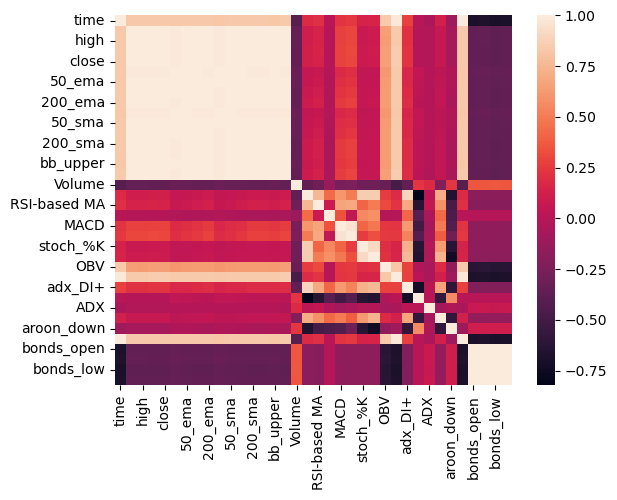

In [383]:
sns.heatmap(qqq.corr())

## Graphs of Indicators/Features

Text(0, 0.5, 'Price ($)')

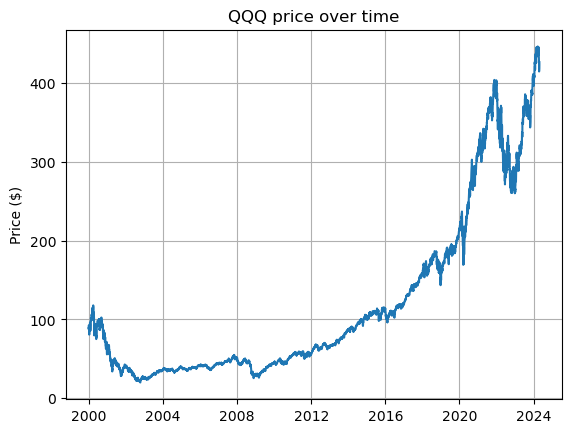

In [385]:
# Close price
plt.plot(qqq.time, qqq.close)
plt.title('QQQ price over time')
plt.grid()
plt.ylabel('Price ($)')

Text(0.5, 1.0, 'QQQ Volume over time')

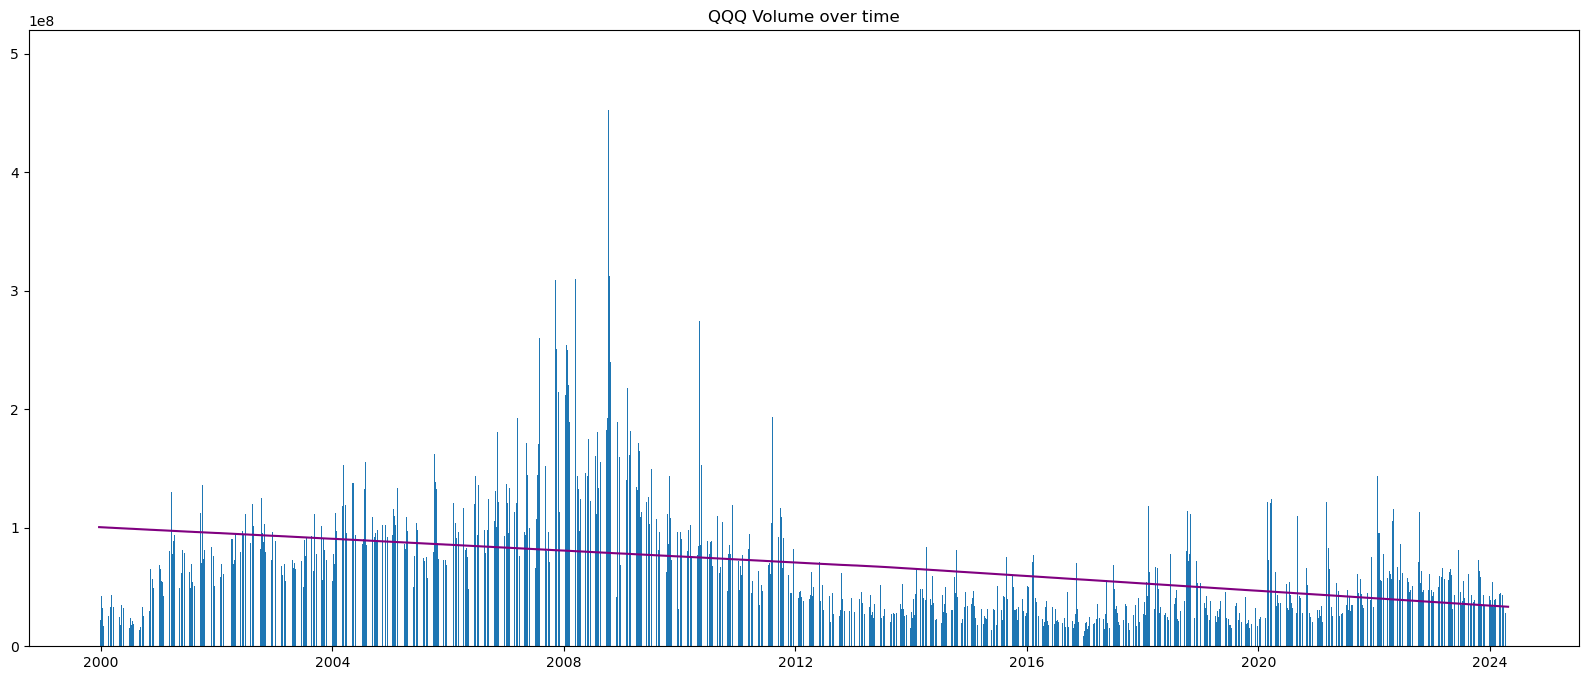

In [386]:
# Volume

plt.figure(figsize = (20,8))

plt.bar(qqq.time, qqq.Volume)

# adding a trend line
lin_model = LinearRegression()

x = np.array(range(len(qqq))).reshape(-1, 1)
lin_model.fit(x, qqq.Volume.values)
vol_lintrend = lin_model.predict(x)

plt.plot(qqq.time, vol_lintrend, color = 'purple')

plt.title('QQQ Volume over time')

In [387]:
# RSI
qqq_monthly = qqq.groupby(qqq['time'].dt.to_period('M')).last()

lin_model = LinearRegression()
x = np.array(range(len(qqq_monthly))).reshape(-1, 1)
lin_model.fit(x, qqq_monthly.RSI.values)
rsi_trend = lin_model.predict(x)

lin_model.fit(x, qqq_monthly['RSI-based MA'].values)
rsiMA_trend = lin_model.predict(x)

fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('QQQ Monthly RSI', 'QQQ Monthly RSI Moving Average'), vertical_spacing = 0.1)

fig.add_trace(go.Bar(name = 'QQQ Monthly RSI', x = qqq_monthly.time, y = qqq_monthly.RSI), row = 1, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = rsi_trend, mode = 'lines', name = 'Linear Trend Line'), row = 1, col = 1)
fig.add_trace(go.Bar(name = 'QQQ Monthly RSI MA', x = qqq_monthly.time, y = qqq_monthly['RSI-based MA']), row = 2, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = rsiMA_trend, mode = 'lines', name = 'Linear Trend Line'), row = 2, col = 1)

fig.update_layout(height = 850, width = 1100)

fig.show()

C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [388]:
# MACD

# trend line
lin_model = LinearRegression()

x = np.array(range(len(qqq))).reshape(-1, 1)
lin_model.fit(x, qqq.macd_hist.values)
macd_hist_lintrend = lin_model.predict(x)

lin_model.fit(x, qqq.MACD)
macd_lintrend = lin_model.predict(x)

lin_model.fit(x, qqq.macd_signal)
macd_signal_lintrend = lin_model.predict(x)

# plotly
fig = make_subplots(rows = 3, cols = 1, subplot_titles = ('QQQ MACD Histogram', 'QQQ MACD', 'QQQ MACD Signal'), vertical_spacing = 0.1)

fig.add_trace(go.Bar(name = 'QQQ MACD Hist', x = qqq_monthly.time, y = qqq_monthly.macd_hist), row = 1, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = macd_hist_lintrend, mode = 'lines', name = 'MACD Hist Linear'), row = 1, col = 1)
fig.add_trace(go.Scatter(name = 'QQQ MACD', x = qqq_monthly.time, y = qqq_monthly['MACD']), row = 2, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = macd_lintrend, mode = 'lines', name = 'MACD Linear'), row = 2, col = 1)
fig.add_trace(go.Scatter(name = 'QQQ MACD Signal', x = qqq_monthly.time, y = qqq_monthly.macd_signal), row = 3, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = macd_signal_lintrend, mode = 'lines', name = 'MACD Signal Linear'), row = 3, col = 1)

fig.update_layout(height = 850, width = 1000)

fig.show()

C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [389]:
fig = make_subplots(rows = 3, cols = 1, subplot_titles = ('QQQ MACD Histogram', 'QQQ MACD', 'QQQ MACD Signal'), vertical_spacing = 0.1)

fig.add_trace(go.Histogram(x = qqq.macd_hist, name = 'MACD Histogram'), row = 1, col = 1)
fig.add_trace(go.Histogram(x = qqq.MACD, name = 'MACD'), row = 2, col = 1)
fig.add_trace(go.Histogram(x = qqq.macd_signal, name = 'MACD Signal'), row = 3, col = 1)

fig.update_layout(height = 850, width = 1000)

fig.show()

In [390]:
# Stochastic 
fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('Stochastic Oscillator %K', 'Stochastic Oscillator %D'), vertical_spacing = 0.1)

lin_model = LinearRegression()

x = np.array(range(len(qqq_monthly))).reshape(-1, 1)
lin_model.fit(x, qqq_monthly['stoch_%K'].values)
stochK_lintrend = lin_model.predict(x)

lin_model.fit(x, qqq_monthly['stoch_%D'])
stochD_lintrend = lin_model.predict(x)

fig.add_trace(go.Bar(name = 'QQQ Stochastic %K', x = qqq_monthly.time, y = qqq_monthly['stoch_%K']), row = 1, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = stochK_lintrend, mode = 'lines', name = 'stoch_%K Linear'), row = 1, col = 1)
fig.add_trace(go.Bar(name = 'QQQ Stochastic %D', x = qqq_monthly.time, y = qqq_monthly['stoch_%D']), row = 2, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = stochD_lintrend, mode = 'lines', name = 'stoch_%D Linear'), row = 2, col = 1)

fig.update_layout(height = 850, 
                  width = 1150,
                  bargap = 0,
                  bargroupgap = 0)

fig.update_traces(marker_color='blue',
                  marker_line_color='blue',
                  selector=dict(type="bar"))

fig.show()

C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [391]:
fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('QQQ Stochastic %K', 'QQQ Stochastic %D'), vertical_spacing = 0.1)

fig.add_trace(go.Histogram(x = qqq['stoch_%K'], name = 'Stoch %K'), row = 1, col = 1)
fig.add_trace(go.Histogram(x = qqq['stoch_%D'], name = 'Stoch %D'), row = 2, col = 1)

fig.update_layout(height = 850, width = 1000)

fig.show()

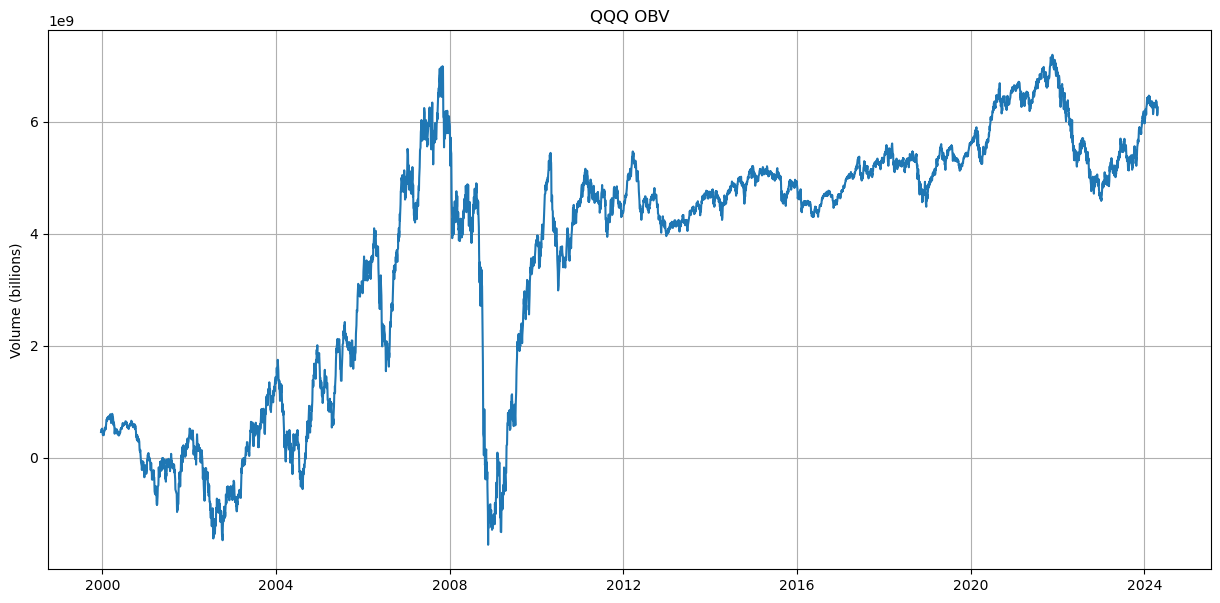

In [392]:
# On Balance Value
plt.figure(figsize = (15,7))
plt.plot(qqq.time, qqq.OBV)
plt.title('QQQ OBV')
plt.ylabel('Volume (billions)')
plt.grid()
plt.show()

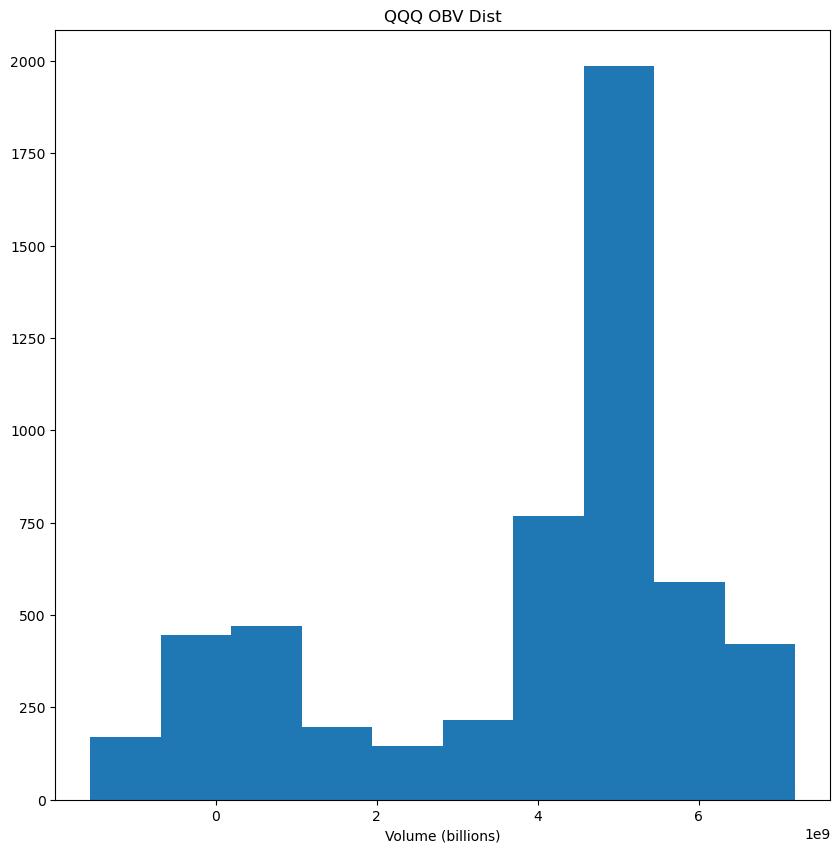

In [393]:
plt.figure(figsize = (10,10))
plt.hist(qqq.OBV)
plt.title('QQQ OBV Dist')
plt.xlabel('Volume (billions)')
plt.show()

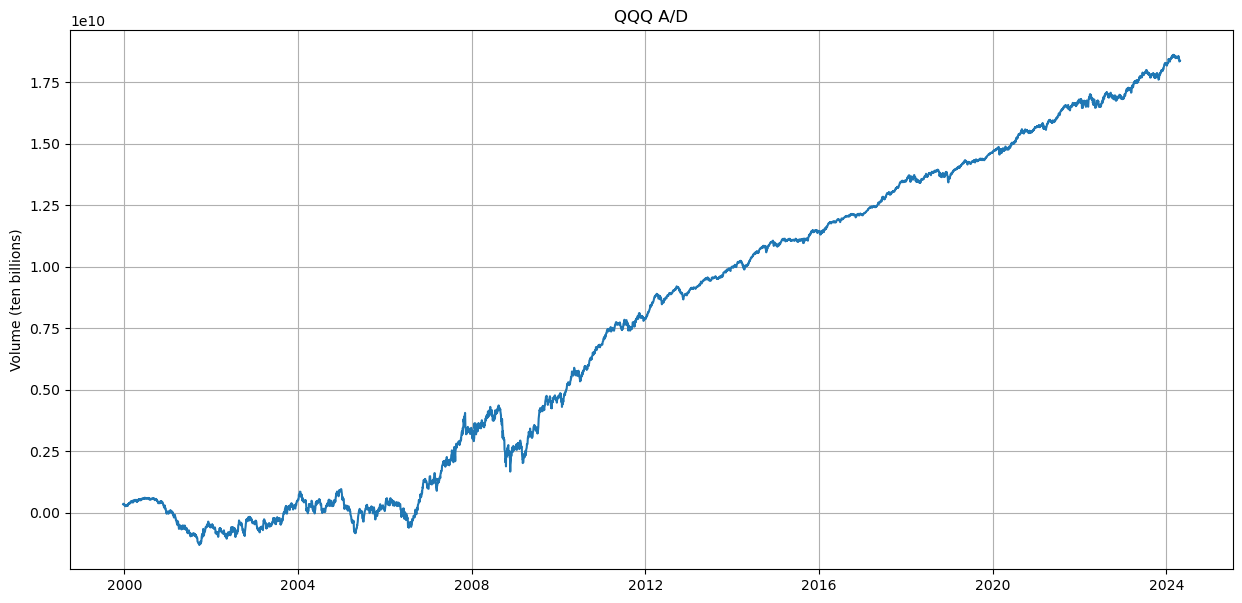

In [394]:
# A/D
plt.figure(figsize = (15,7))
plt.plot(qqq.time, qqq['A/D'])
plt.title('QQQ A/D')
plt.ylabel('Volume (ten billions)')
plt.grid()
plt.show()

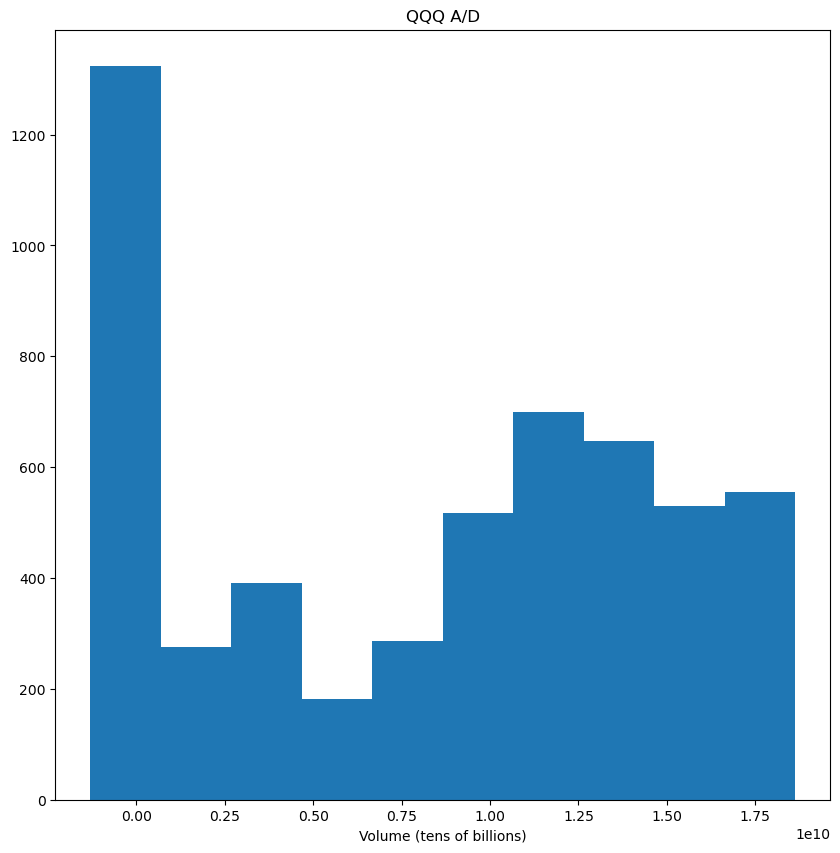

In [395]:
plt.figure(figsize = (10,10))
plt.hist(qqq['A/D'])
plt.title('QQQ A/D')
plt.xlabel('Volume (tens of billions)')
plt.show()

In [396]:
# ADX

lin_model = LinearRegression()

x = np.array(range(len(qqq))).reshape(-1, 1)
lin_model.fit(x, qqq['ADX'].values)
adx_lintrend = lin_model.predict(x)

fig = go.Figure()
fig.add_trace(go.Bar(name = 'QQQ ADX', x = qqq.time, y = qqq['ADX']))
fig.add_trace(go.Scatter(x = qqq.time, y = adx_lintrend, mode = 'lines', name = 'ADX Linear'))

fig.update_layout(height = 700, 
                  width = 1150,
                  title = 'QQQ ADX',
                  xaxis_title = 'Date',
                  yaxis_title = 'ADX',
                  bargap = 0,
                  bargroupgap = 0)

fig.update_traces(marker_color = 'blue',
                  marker_line_color = 'blue',
                  selector = dict(type = 'bar'))

fig.show()


C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



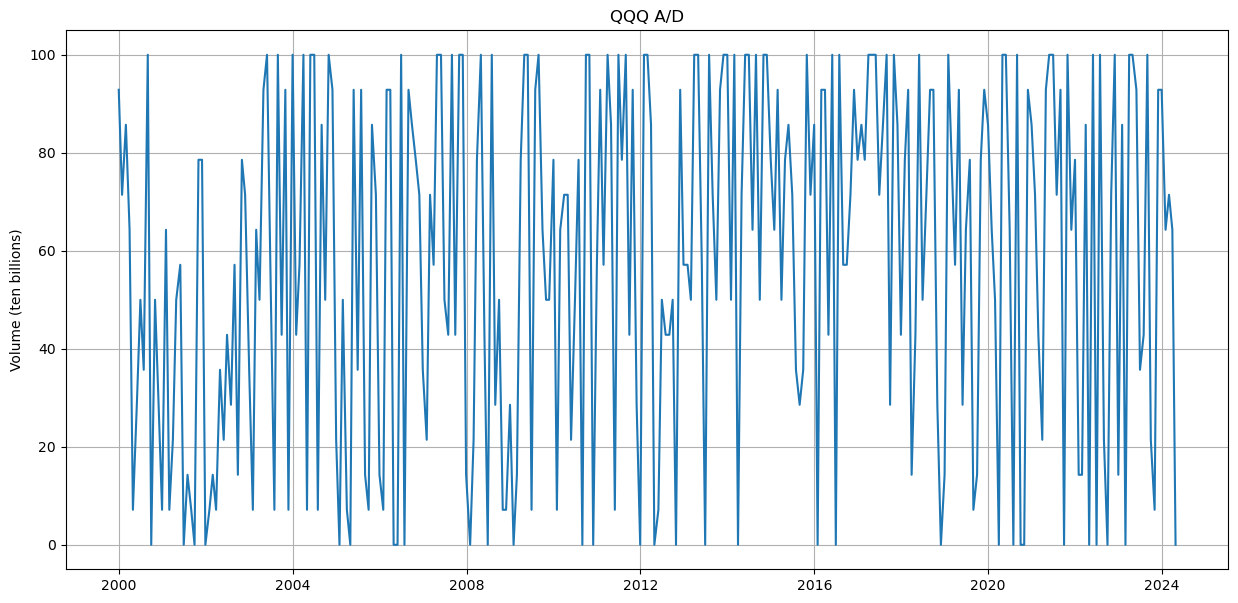

In [397]:
# Aroon
plt.figure(figsize = (15,7))
plt.plot(qqq_monthly.time, qqq_monthly.aroon_up)
plt.title('QQQ A/D')
plt.ylabel('Volume (ten billions)')
plt.grid()
plt.show()

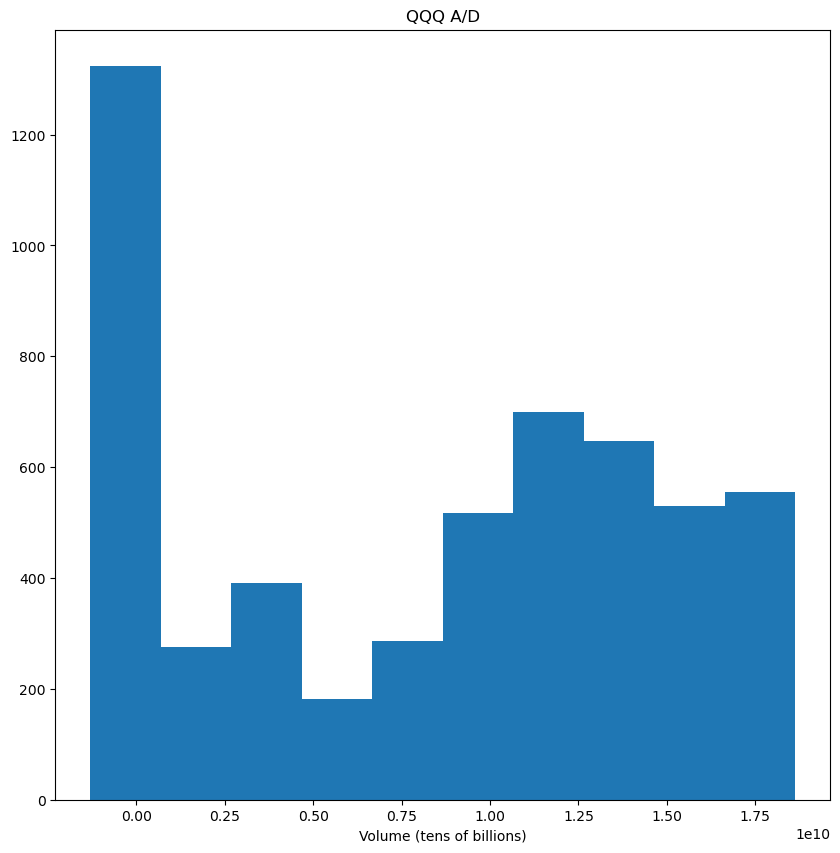

In [398]:
plt.figure(figsize = (10,10))
plt.hist(qqq['A/D'])
plt.title('QQQ A/D')
plt.xlabel('Volume (tens of billions)')
plt.show()

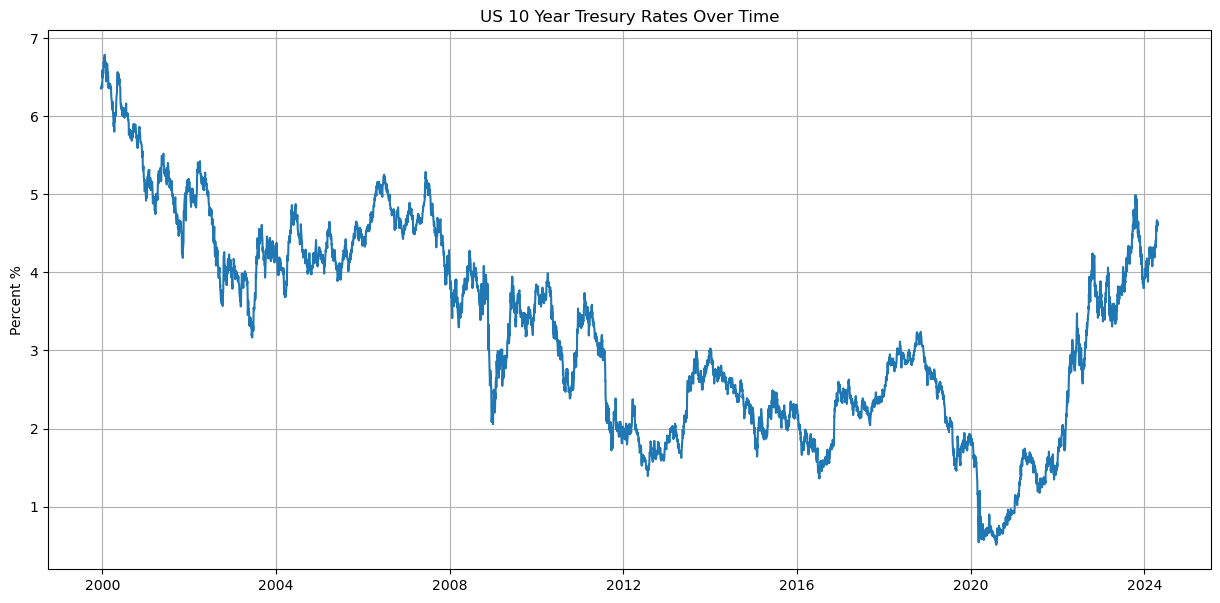

In [399]:
# Bonds 10Y
plt.figure(figsize = (15,7))
plt.plot(qqq.time, qqq.bonds_close)
plt.title('US 10 Year Tresury Rates Over Time')
plt.ylabel('Percent %')
plt.grid()
plt.show()

# Feature Engineering

In [7]:
qqq.columns

Index(['time', 'open', 'high', 'low', 'close', '20_ema', '50_ema', '100_ema',
       '200_ema', '20_sma', '50_sma', '100_sma', '200_sma', 'bb_basis',
       'bb_upper', 'bb_lower', 'Volume', 'RSI', 'RSI-based MA', 'macd_hist',
       'MACD', 'macd_signal', 'stoch_%K', 'stoch_%D', 'OBV', 'A/D', 'adx_DI+',
       'adx_DI-', 'ADX', 'aroon_up', 'aroon_down', 'bonds_time', 'bonds_open',
       'bonds_high', 'bonds_low', 'bonds_close'],
      dtype='object')

## Understanding the columns/indicators

In [403]:

"""
Most of the information here will be coming from Investopedia

EMA vs SMA -> EMA places more weight on most recent data points while SMA evenly dispereses weight. EMA more reactive to to recent data
              Additionally, shorter time periods in general more responsive to recent data, longer periods for viewing longer trends
              
bb's -> bb_basis, bb_upper, bb_lower
        bollinger bands with 1 stdev above and below, the basis line in this case utilizes a 20 day SMA
        
Volume -> the volume, could be indicative of momentum but more difficult to tell with just the overall volume
          another indicator with the amount of in/outflow would be more helpful in conjunction with total volume
          
RSI -> RSI, RSI-based MA
       momentum indicator measuring speed and magnitude of recent price changes
       oscillator from 0 - 100
       This case is a 70/30 RSI with a 14 day period (SMA)
       Due to the 14 day period, it is a relatively short term oscillator, being most effective for the next few 
           days to next few weeks tops (lets say 2 weeks)
       
MACD -> macd_hist, MACD, macd_signal
        Momentum indicator
        On TradingView, the indicator is broken up into 3 components: the histogram, the MACD line, and the signal line
        MACD histogram tracks the difference between the fast MACD line and the signal line
        MACD line calculated by the differnce between long EMA and short EMA (Fast - Slow, 12 EMA - 26 EMA)
        MACD Signal = 9 day EMA
        The settings for this data were:
            Fast length: 12
            Slow length: 26
            Source: close
            Signal smoothing: 9
            Oscillator MA: EMA
            Signal line MA: EMA
        So again, these settings in specific are better for shorter term periods, like next days to weeks

Stochastic Oscillator -> stoch_%K, stoch_%D
                         momentum oscillator & indicator
                             helps determine trends & reversals
                         tends to vary around some mean price level
                         Settings:
                             %K Length: 14
                             %K Smoothing: 1
                             %D Smoothing: 3
                         %K = "fast" stochastic indicator
                         %D = "slow" stochastic indicator
                         Signals generated when %K crosses through %D

On Balance Volume -> OBV
                     Momentum (bullish/bearish)
                         Accumulation-distribution tool that tallies up & down volume 
                     Works best near major highs and lows, better to track direction of OBV line 
                         volume supporting price action --> convergence, makes directional signals more reliable
                         oppsing action --> divergence

Accumulation/Distribution -> A/D
                             gauges supply and demand of asset by looking at close price (within a period) times volume
                                 indicator is cumulative (period n+1 - period n)
                                 helps confirm price trend
                                     rising A/D --> rising price trend and vice versa

Average Directional Index -> adx_DI+, adx_DI-, ADX
                             quantify trend strength
                                 based on moving average of a period
                                 range of 0 - 100
                                 non-directional
                             plotted with 2 directionam movement indicator lines (DMI or DI)
                                 when DI+ is above DI- --> prices moving up & ADX measures strength of uptrend
                                 when DI- above DI+ --> prices moving down and ADX measures strength of downtrend
                             Reading ADX:
                                 0-25: absent or weak trend
                                 25-50: strong trend
                                 50-75: very strong trend
                                 75-100: extremely strong trend
                             low ADX usually a sign of accumulation or distribution
                                 ADX < 25 for more than 30 bars (i guess 30 days) -> price enters "range conditions" and price patterns easier to find

Aroon Indicator -> aroon_up, aroon_down
                   identifies trend changes and trend strength
                       measures time between hights and lows over a period
                       strong uptrends will regularly see new highs and vice versa
                   aroon up for strength of uptrend, aroon down for strngth of downtrend

bonds -> bonds_time, bonds_open, bonds_high, bonds_low, bonds_close
         important economic/financial measure
             Rising yield indicates investor confidence in economy, but also suggests higher borrowing costs -> potentially slowing economic growth
             Falling yield may signal economic uncertainty -> recession, bear market, etc.
             Yields maintained at certain levels can indicate things too
                 Take the low interest in the 2010s
                     Caused the rampant growth of the tech sector as risk-averse investors piled money in at low rates
                 

A number of the indicators talk about resistances and supports, these numerically are kind of harder to establish that on a graph
    Resistances and supports can come from various periods so will be using certain ranges to identify these levels
    20, 50, 100, and 200 day highs and lows will become these levels
                                 
"""

'\nMost of the information here will be coming from Investopedia\n\nEMA vs SMA -> EMA places more weight on most recent data points while SMA evenly dispereses weight. EMA more reactive to to recent data\n              Additionally, shorter time periods in general more responsive to recent data, longer periods for viewing longer trends\n              \nbb\'s -> bb_basis, bb_upper, bb_lower\n        bollinger bands with 1 stdev above and below, the basis line in this case utilizes a 20 day SMA\n        \nVolume -> the volume, could be indicative of momentum but more difficult to tell with just the overall volume\n          another indicator with the amount of in/outflow would be more helpful in conjunction with total volume\n          \nRSI -> RSI, RSI-based MA\n       momentum indicator measuring speed and magnitude of recent price changes\n       oscillator from 0 - 100\n       This case is a 70/30 RSI with a 14 day period (SMA)\n       Due to the 14 day period, it is a relatively sho

In [9]:
# Grouping the indicators into categories

"""
SMA - general usage
EMA - more effective with recent data
Volume
Bonds

overbought/oversold
 - RSI
 - MACD
 - Stochastic oscillator

trend Strength, momentum
 - A/D
 - ADX
 - Aroon
 - OBV 
   -> Although OBV is a volume measuring tool, it does help in identify trend strength


"""

'\nSMA - general usage\nEMA - more effective with recent data\nVolume\nBonds\n\noverbought/oversold\n - RSI\n - MACD\n - Stochastic oscillator\n\ntrend Strength, momentum\n - A/D\n - ADX\n - Aroon\n - OBV \n   -> Although OBV is a volume measuring tool, it does help in identify trend strength\n\n\n'

## RSI features

In [11]:
# RSI features
#  overbought/oversold
#  cross overs
#  rolling stats
#  rate of change
#   rate of change over slope

In [12]:
# Overbought/oversold -> 70/30

def rsi_lvl(rsi):
    if rsi >= 70:
        return(4) # overbought
    elif (rsi < 70 and rsi >= 50):
        return(3)
    elif (rsi < 50 and rsi > 30):
        return(2)
    elif rsi <= 30:
        return (1) # oversold
    

qqq.loc[:, 'rsi_lvl'] = qqq['RSI'].map(rsi_lvl)
qqq.loc[:, 'rsiMA_lvl'] = qqq['RSI-based MA'].map(rsi_lvl)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\344745077.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'rsi_lvl'] = qqq['RSI'].map(rsi_lvl)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\344745077.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'rsiMA_lvl'] = qqq['RSI-based MA'].map(rsi_lvl)


In [13]:
# Cross overs
#  RSI crosses above SMA -> uptrend, buy signal, strengthening uptrend
#  RSI crosses below SMA -> weakening momentum, sell signal

# using np.where() for better performance
qqq.loc[:,'prev_rsi'] = qqq['RSI'].shift(1)
qqq.loc[:,'prev_rsiMA'] = qqq['RSI-based MA'].shift(1)

# Detect crossovers
qqq.loc[:,'rsi_cross'] = np.where(
    (qqq['RSI'] > qqq['RSI-based MA']) & (qqq['prev_rsi'] <= qqq['prev_rsiMA']), 1, # 1 for positive cross
    np.where(
        (qqq['RSI'] < qqq['RSI-based MA']) & (qqq['prev_rsi'] >= qqq['prev_rsiMA']), 0, # 0 for negative cross
        np.nan
    )
)

# drop the columns
qqq.drop(columns = ['prev_rsi', 'prev_rsiMA'])

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3481303131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'prev_rsi'] = qqq['RSI'].shift(1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3481303131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'prev_rsiMA'] = qqq['RSI-based MA'].shift(1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3481303131.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

time        open      high         low      close      20_ema  \
157  1999-12-21   85.125000   88.7500   84.640625   88.68750   60.110507   
158  1999-12-22   89.187500   89.3125   87.437500   89.15625   60.399520   
159  1999-12-23   89.867185   90.7500   89.000000   89.65625   60.690632   
160  1999-12-28   89.750000   90.5000   88.562500   89.18750   61.259838   
161  1999-12-29   90.000000   92.5000   89.875000   92.50000   61.570685   
...         ...         ...       ...         ...        ...         ...   
5559 2024-04-18  426.490000  428.2400  422.830000  423.41000  398.709452   
5560 2024-04-19  422.220000  422.7500  413.070000  414.65000  398.868064   
5561 2024-04-22  417.310000  421.1800  413.940000  418.82000  399.066591   
5562 2024-04-23  420.770000  426.2800  418.871500  425.07000  399.325331   
5563 2024-04-24  428.200000  429.7300  424.200000  426.51000  399.595825   

          50_ema     100_ema     200_ema      20_sma  ...    aroon_up  \
157    68.186756   73.845401   79.864289   60.110507  ...  100.000000   
158    68.601994   74.445827   80.749238   60.300976  ...  100.000000   
159    69.018910   75.042314   81.597524   60.492695  ...  100.000000   
160    69.819462   76.148826   83.017475   60.879257  ...   92.857143   
161    70.268582   76.790048   83.920572   61.082070  ...   85.714286   
...          ...         ...         ...         ...  ...         ...   
5559  421.574777  433.896839  436.434436  395.910200  ...    7.142857   
5560  421.437652  433.142061  434.359728  396.132050  ...    0.000000   
5561  421.385818  432.580412  432.879754  396.388850  ...   14.285714   
5562  421.458772  432.285886  432.135968  396.683000  ...    7.142857   
5563  421.558796  432.059381  431.600161  396.983750  ...    0.000000   

      aroon_down  bonds_time  bonds_open  bonds_high  bonds_low  bonds_close  \
157     0.000000  1999-12-21       6.358       6.358      6.358        6.358   
158     0.000000  1999-12-22       6.376       6.376      6.376        6.376   
159    28.571429  1999-12-23       6.376       6.376      6.376        6.376   
160    14.285714  1999-12-28       6.399       6.399      6.399        6.399   
161     7.142857  1999-12-29       6.417       6.417      6.417        6.417   
...          ...         ...         ...         ...        ...          ...   
5559  100.000000  2024-04-18       4.591       4.651      4.561        4.635   
5560  100.000000  2024-04-19       4.637       4.637      4.496        4.623   
5561   92.857143  2024-04-22       4.643       4.668      4.608        4.611   
5562   85.714286  2024-04-23       4.611       4.652      4.570        4.602   
5563   78.571429  2024-04-24       4.605       4.669      4.602        4.646   

      rsi_lvl  rsiMA_lvl  rsi_cross  
157         4          3        NaN  
158         4          4        NaN  
159         4          4        NaN  
160         4          4        NaN  
161         4          4        NaN  
...       ...        ...        ...  
5559        2          2        NaN  
5560        1          2        NaN  
5561        2          2        NaN  
5562        2          2        NaN  
5563        2          2        NaN  

[5407 rows x 39 columns]

In [14]:
# rolling stats
qqq.loc[:,'mean_rsi_5D'] = qqq.loc[:,'RSI'].rolling(window=5).mean()
qqq.loc[:,'std_rsi_5D'] = qqq.loc[:,'RSI'].rolling(window=5).std()
qqq.loc[:,'mean_rsi_14D'] = qqq.loc[:,'RSI'].rolling(window=14).mean()
qqq.loc[:,'std_rsi_14D'] = qqq.loc[:,'RSI'].rolling(window=14).std()

qqq.loc[:,'mean_rsiMA_5D'] = qqq.loc[:,'RSI-based MA'].rolling(window=5).mean()
qqq.loc[:,'std_rsiMA_5D'] = qqq.loc[:,'RSI-based MA'].rolling(window=5).std()
qqq.loc[:,'mean_rsiMA_14D'] = qqq.loc[:,'RSI-based MA'].rolling(window=14).mean()
qqq.loc[:,'std_rsiMA_14D'] = qqq.loc[:,'RSI-based MA'].rolling(window=14).std()

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\4211394225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_rsi_5D'] = qqq.loc[:,'RSI'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\4211394225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'std_rsi_5D'] = qqq.loc[:,'RSI'].rolling(window=5).std()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\4211394225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [15]:
# rate of change
qqq.loc[:,'roc_rsi_1D'] = qqq.loc[:,'RSI'].pct_change(periods=1)
qqq.loc[:,'roc_rsi_5D'] = qqq.loc[:,'RSI'].pct_change(periods=5)
qqq.loc[:,'roc_rsi_14D'] = qqq.loc[:,'RSI'].pct_change(periods=14)

qqq.loc[:,'roc_rsiMA_1D'] = qqq.loc[:,'RSI-based MA'].pct_change(periods=1)
qqq.loc[:,'roc_rsiMA_5D'] = qqq.loc[:,'RSI-based MA'].pct_change(periods=5)
qqq.loc[:,'roc_rsiMA_14D'] = qqq.loc[:,'RSI-based MA'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2223099904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_rsi_1D'] = qqq.loc[:,'RSI'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2223099904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_rsi_5D'] = qqq.loc[:,'RSI'].pct_change(periods=5)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2223099904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

## MACD features

In [17]:
# MACD features
# macd_hist can be like the magnitude
# crossing signals
#  finding when macd_hist changes between negative and positive 
#  -> it is the difference between the signal and MACD line, so when it passes zero = crossover of lines
# slope?
#  rapid rise/falls -> momentum of overbought/oversold (in tandem with RSI)
# rolling stats
# rate of change

In [18]:
# macd_hist_cross
#  There are signals whenever the MACD line crosses over the signal line
#  Since the macd_hist = MACD - Signal, can just use this value to see whenever the MACD crosses over

## Loop approach in this case/scale is not necessarily slower, but on larger datasets it may perform worse
# macd_cross = ['none']

# for i in range(1, len(qqq)):
#     curr = qqq.macd_hist.iloc[i]
#     prev = qqq.macd_hist.iloc[i - 1]
#     if (curr > 0) and (prev < 0):
#         macd_cross.append('pos_cross')
#     elif (curr < 0) and (prev > 0):
#         macd_cross.append('neg_cross')
#     else:
#         macd_cross.append('none')
    
# qqq.macd_cross = macd_cross

# Vectorized approach
# (qqq.macd_hist.shift(1) * qqq.macd_hist < 0) -> checks if x * y is negative or not as negative would mean a sign change
# (qqq.macd_hist.shift(1) <> qqq.macd_hist) -> checks if shifted value (n + 1) is higher/lower than n to see which is higher
qqq.loc[:,'macd_hist_cross'] = np.where((qqq.macd_hist.shift(1) * qqq.macd_hist < 0) & (qqq.macd_hist.shift(1) < qqq.macd_hist), 1,     
                              np.where((qqq.macd_hist.shift(1) * qqq.macd_hist < 0) & (qqq.macd_hist.shift(1) > qqq.macd_hist), 0,
                                       np.nan)
                             )

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2470239617.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'macd_hist_cross'] = np.where((qqq.macd_hist.shift(1) * qqq.macd_hist < 0) & (qqq.macd_hist.shift(1) < qqq.macd_hist), 1,


In [19]:
# MACD slope

qqq.loc[:, 'macd_1Dslope'] = qqq.loc[:,'MACD'] - qqq.loc[:,'MACD'].shift(1)
qqq.loc[:, 'macd_5Dslope'] = (qqq.loc[:, 'MACD'] - qqq.loc[:, 'MACD'].shift(5)) / 5
qqq.loc[:, 'macd_14Dslope'] = (qqq.loc[:, 'MACD'] - qqq.loc[:, 'MACD'].shift(14)) / 14

qqq.loc[:, 'macd_signal_1Dslope'] = qqq.loc[:, 'macd_signal'] - qqq.loc[:, 'macd_signal'].shift(1)
qqq.loc[:, 'macd_signal_5Dslope'] = (qqq.loc[:, 'macd_signal'] - qqq.loc[:, 'macd_signal'].shift(5)) / 5
qqq.loc[:, 'macd_signal_14Dslope'] = (qqq.loc[:, 'macd_signal'] - qqq.loc[:, 'macd_signal'].shift(14)) / 14

qqq.loc[:, ['macd_1Dslope', 'macd_5Dslope', 'macd_14Dslope', 
            'macd_signal_1Dslope', 'macd_signal_5Dslope', 'macd_signal_14Dslope']] = qqq.loc[:, ['macd_1Dslope', 'macd_5Dslope', 'macd_14Dslope', 
                                                                                                'macd_signal_1Dslope', 'macd_signal_5Dslope',
                                                                                                'macd_signal_14Dslope']].fillna(0)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1749252719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'macd_1Dslope'] = qqq.loc[:,'MACD'] - qqq.loc[:,'MACD'].shift(1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1749252719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'macd_5Dslope'] = (qqq.loc[:, 'MACD'] - qqq.loc[:, 'MACD'].shift(5)) / 5
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1749252719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

In [20]:
# rolling stats
qqq.loc[:,'mean_macd_5D'] = qqq.loc[:,'MACD'].rolling(window=5).mean()
qqq.loc[:,'std_macd_5D'] = qqq.loc[:,'MACD'].rolling(window=5).std()
qqq.loc[:,'mean_macd_14D'] = qqq.loc[:,'MACD'].rolling(window=14).mean()
qqq.loc[:,'std_macd_14D'] = qqq.loc[:,'MACD'].rolling(window=14).std()

qqq.loc[:,'mean_macd_signal_5D'] = qqq.loc[:,'macd_signal'].rolling(window=5).mean()
qqq.loc[:,'std_macd_signal_5D'] = qqq.loc[:,'macd_signal'].rolling(window=5).std()
qqq.loc[:,'mean_macd_signal_14D'] = qqq.loc[:,'macd_signal'].rolling(window=14).mean()
qqq.loc[:,'std_macd_signal_14D'] = qqq.loc[:,'macd_signal'].rolling(window=14).std()

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2200457167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_macd_5D'] = qqq.loc[:,'MACD'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2200457167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'std_macd_5D'] = qqq.loc[:,'MACD'].rolling(window=5).std()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2200457167.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [21]:
# rate of change
qqq.loc[:,'roc_macd_1D'] = qqq.loc[:,'MACD'].pct_change(periods=1)
qqq.loc[:,'roc_macd_5D'] = qqq.loc[:,'MACD'].pct_change(periods=5)
qqq.loc[:,'roc_macd_14D'] = qqq.loc[:,'MACD'].pct_change(periods=14)

qqq.loc[:,'roc_macd_signal_1D'] = qqq.loc[:,'macd_signal'].pct_change(periods=1)
qqq.loc[:,'roc_macd_signal_5D'] = qqq.loc[:,'macd_signal'].pct_change(periods=5)
qqq.loc[:,'roc_macd_signal_14D'] = qqq.loc[:,'macd_signal'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2899194821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_macd_1D'] = qqq.loc[:,'MACD'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2899194821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_macd_5D'] = qqq.loc[:,'MACD'].pct_change(periods=5)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2899194821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

## Stochastic Oscillator

In [23]:
# Settings:
#     %K Length: 14
#         %K = "fast" stochastic indicator
#     %K Smoothing: 1
#     %D Smoothing: 3
#         %D = "slow" stochastic indicator
                         
# Stochastic Oscillator Features
#  overbought/oversold
#  crossing
#  slope
#  rolling stats
#  rate of change

In [24]:
# Overbought/oversold
# 80/20

# https://stackoverflow.com/questions/39109045/numpy-where-with-multiple-conditions
# neater way of implementing vectorized conditionals than previous np.where() method

cond1 = [qqq.loc[:, 'stoch_%K'] >= 80,
         (qqq.loc[:, 'stoch_%K'] < 80) & (qqq.loc[:, 'stoch_%K'] > 50),
         (qqq.loc[:, 'stoch_%K'] < 50) & (qqq.loc[:, 'stoch_%K'] > 20),
         qqq.loc[:, 'stoch_%K'] <= 20]

cond2 = [qqq.loc[:, 'stoch_%D'] >= 80,
         (qqq.loc[:, 'stoch_%D'] < 80) & (qqq.loc[:, 'stoch_%D'] > 50),
         (qqq.loc[:, 'stoch_%D'] < 50) & (qqq.loc[:, 'stoch_%D'] > 20),
         qqq.loc[:, 'stoch_%D'] <= 20]

outp = [4, 3, 2, 1] # 'ob', 'up_neu', 'low_neu', 'os'

qqq.loc[:, 'stochK_lvl'] = np.select(cond1, outp, default = np.nan)
qqq.loc[:, 'stochD_lvl'] = np.select(cond2, outp, default = np.nan)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1750409764.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'stochK_lvl'] = np.select(cond1, outp, default = np.nan)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1750409764.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'stochD_lvl'] = np.select(cond2, outp, default = np.nan)


In [25]:
# rolling stats
qqq.loc[:,'mean_%K_5D'] = qqq.loc[:,'stoch_%K'].rolling(window=5).mean()
qqq.loc[:,'std_%K_5D'] = qqq.loc[:,'stoch_%K'].rolling(window=5).std()
qqq.loc[:,'mean_%K_14D'] = qqq.loc[:,'stoch_%K'].rolling(window=14).mean()
qqq.loc[:,'std_%K_14D'] = qqq.loc[:,'stoch_%K'].rolling(window=14).std()

qqq.loc[:,'mean_%D_5D'] = qqq.loc[:,'stoch_%D'].rolling(window=5).mean()
qqq.loc[:,'std_%D_5D'] = qqq.loc[:,'stoch_%D'].rolling(window=5).std()
qqq.loc[:,'mean_%D_14D'] = qqq.loc[:,'stoch_%D'].rolling(window=14).mean()
qqq.loc[:,'std_%D_14D'] = qqq.loc[:,'stoch_%D'].rolling(window=14).std()

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2949865540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_%K_5D'] = qqq.loc[:,'stoch_%K'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2949865540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'std_%K_5D'] = qqq.loc[:,'stoch_%K'].rolling(window=5).std()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2949865540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [290]:
# rate of change
qqq.loc[:,'roc_%K_1D'] = qqq.loc[:,'stoch_%K'].pct_change(periods=1)
qqq.loc[:,'roc_%K_5D'] = qqq.loc[:,'stoch_%K'].pct_change(periods=5)
qqq.loc[:,'roc_%K_14D'] = qqq.loc[:,'stoch_%K'].pct_change(periods=14)

qqq.loc[:,'roc_%D_1D'] = qqq.loc[:,'stoch_%D'].pct_change(periods=1)
qqq.loc[:,'roc_%D_5D'] = qqq.loc[:,'stoch_%D'].pct_change(periods=5)
qqq.loc[:,'roc_%D_14D'] = qqq.loc[:,'stoch_%D'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1099876963.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  qqq.loc[:,'roc_%K_1D'] = qqq.loc[:,'stoch_%K'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1099876963.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  qqq.loc[:,'roc_%K_5D'] = qqq.loc[:,'stoch_%K'].pct_change(periods=5)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1099876963.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to 

## Volume and OBV

In [28]:
# Volume and OBV
#  slope
#  rolling stats
#  rate of change

qqq[['Volume', 'OBV']]

Volume           OBV
157   26003398  4.590970e+08
158   22313602  4.814106e+08
159   17542000  4.989526e+08
160   15345398  5.028900e+08
161   16512398  5.194024e+08
...        ...           ...
5559  46549363  6.189428e+09
5560  75230990  6.114197e+09
5561  47807663  6.162005e+09
5562  44335944  6.206390e+09
5563  48405226  6.254830e+09

[5407 rows x 2 columns]

In [29]:
# slope
qqq.loc[:, 'vol_1D_slope'] = qqq.loc[:,'Volume'] - qqq.loc[:, 'Volume'].shift(1)
qqq.loc[:, 'vol_5D_slope'] = (qqq.loc[:,'Volume'] - qqq.loc[:, 'Volume'].shift(5)) / 5
qqq.loc[:, 'vol_14D_slope'] = (qqq.loc[:,'Volume'] - qqq.loc[:, 'Volume'].shift(14)) / 14

qqq.loc[:, 'obv_1D_slope'] = qqq.loc[:,'OBV'] - qqq.loc[:, 'OBV'].shift(1)
qqq.loc[:, 'obv_5D_slope'] = (qqq.loc[:,'OBV'] - qqq.loc[:, 'OBV'].shift(5)) / 5
qqq.loc[:, 'obv_14D_slope'] = (qqq.loc[:,'OBV'] - qqq.loc[:, 'OBV'].shift(14)) / 14

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\4254647023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'vol_1D_slope'] = qqq.loc[:,'Volume'] - qqq.loc[:, 'Volume'].shift(1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\4254647023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'vol_5D_slope'] = (qqq.loc[:,'Volume'] - qqq.loc[:, 'Volume'].shift(5)) / 5
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\4254647023.py:4: SettingWithCopyWarning: 
A value is trying to be se

In [30]:
# rolling stats
qqq.loc[:,'mean_vol_5D'] = qqq['Volume'].rolling(window=5).mean()
qqq.loc[:,'std_vol_5D'] = qqq['Volume'].rolling(window=5).std()
qqq.loc[:,'mean_vol_14D'] = qqq['Volume'].rolling(window=14).mean()
qqq.loc[:,'std_vol_14D'] = qqq['Volume'].rolling(window=14).std()

qqq.loc[:,'mean_obv_5D'] = qqq['OBV'].rolling(window=5).mean()
qqq.loc[:,'std_obv_5D'] = qqq['OBV'].rolling(window=5).std()
qqq.loc[:,'mean_obv_14D'] = qqq['OBV'].rolling(window=14).mean()
qqq.loc[:,'std_obv_14D'] = qqq['OBV'].rolling(window=14).std()

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\150090642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_vol_5D'] = qqq['Volume'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\150090642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'std_vol_5D'] = qqq['Volume'].rolling(window=5).std()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\150090642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [31]:
# rate of change
qqq.loc[:,'roc_vol_1D'] = qqq['Volume'].pct_change(periods=1)
qqq.loc[:,'roc_vol_5D'] = qqq['Volume'].pct_change(periods=5)
qqq.loc[:,'roc_vol_14D'] = qqq['Volume'].pct_change(periods=14)

qqq.loc[:,'roc_obv_1D'] = qqq['OBV'].pct_change(periods=1)
qqq.loc[:,'roc_obv_5D'] = qqq['OBV'].pct_change(periods=5)
qqq.loc[:,'roc_obv_14D'] = qqq['OBV'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1012016546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_vol_1D'] = qqq['Volume'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1012016546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_vol_5D'] = qqq['Volume'].pct_change(periods=5)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1012016546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

## A/D

In [33]:
# A/D features
#  Slope
#  Rate of Change
#  Rolling stats

qqq['A/D']

157     3.486509e+08
158     3.672455e+08
159     3.628600e+08
160     3.502603e+08
161     3.667727e+08
            ...     
5559    1.839980e+10
5560    1.834913e+10
5561    1.836577e+10
5562    1.839566e+10
5563    1.838769e+10
Name: A/D, Length: 5407, dtype: float64

In [34]:
# slope
qqq.loc[:, 'a/d_1D_slope'] = qqq.loc[:,'A/D'] - qqq.loc[:, 'A/D'].shift(1)
qqq.loc[:, 'a/d_5D_slope'] = (qqq.loc[:,'A/D'] - qqq.loc[:, 'A/D'].shift(5)) / 5
qqq.loc[:, 'a/d_14D_slope'] = (qqq.loc[:,'A/D'] - qqq.loc[:, 'A/D'].shift(14)) / 14

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3289768621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'a/d_1D_slope'] = qqq.loc[:,'A/D'] - qqq.loc[:, 'A/D'].shift(1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3289768621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'a/d_5D_slope'] = (qqq.loc[:,'A/D'] - qqq.loc[:, 'A/D'].shift(5)) / 5
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3289768621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [35]:
# rate of change
qqq.loc[:,'roc_a/d_1D'] = qqq['A/D'].pct_change(periods=1)
qqq.loc[:,'roc_a/d_5D'] = qqq['A/D'].pct_change(periods=5)
qqq.loc[:,'roc_a/d_14D'] = qqq['A/D'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\17175488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_a/d_1D'] = qqq['A/D'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\17175488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_a/d_5D'] = qqq['A/D'].pct_change(periods=5)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\17175488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [36]:
# rolling stats
qqq.loc[:,'mean_a/d_5D'] = qqq.loc[:,'A/D'].rolling(window=5).mean()
qqq.loc[:,'std_a/d_5D'] = qqq.loc[:,'A/D'].rolling(window=5).std()
qqq.loc[:,'mean_a/d_14D'] = qqq.loc[:,'A/D'].rolling(window=14).mean()
qqq.loc[:,'std_a/d_14D'] = qqq.loc[:,'A/D'].rolling(window=14).std()

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2771390067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_a/d_5D'] = qqq.loc[:,'A/D'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2771390067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'std_a/d_5D'] = qqq.loc[:,'A/D'].rolling(window=5).std()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2771390067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

## ADX

In [38]:
qqq[['adx_DI+', 'adx_DI-', 'ADX']]

adx_DI+    adx_DI-        ADX
157   38.945565  13.110736  28.625475
158   38.419481  12.339700  30.834220
159   40.859769  11.650997  32.496583
160   39.919703   9.201540  36.622470
161   41.850347   8.333166  39.089486
...         ...        ...        ...
5559  15.691033  27.872405  10.537848
5560  13.955596  35.229366  12.700272
5561  12.881310  32.517449  15.698155
5562  17.247687  29.958418  17.239678
5563  19.915916  28.187546  18.132934

[5407 rows x 3 columns]

In [39]:
# Crossing
#  di+ over di- = uptrend
#  di- over di+ = downtrend
#  with ADX measuring the magnitude of the signal

# 2 seperate columns, 1 for trend and 1 for ADX strength
adx_cross_cond = [(qqq.loc[:, 'adx_DI+'] > qqq.loc[:, 'adx_DI-']),
                  (qqq.loc[:, 'adx_DI+'] < qqq.loc[:, 'adx_DI-'])]

adx_lvl_cond = [qqq.loc[:, 'ADX'] < 25,
                (qqq.loc[:, 'ADX'] < 50) & (qqq.loc[:, 'ADX'] >= 25),
                (qqq.loc[:, 'ADX'] < 75) & (qqq.loc[:, 'ADX'] >= 50),
                qqq.loc[:, 'ADX'] >= 75]

adx_cross_outp = [1, 0] # up = 1, down = 0
adx_lvl_outp = [1,2,3,4] # weak, strong, very strong, extremely strong

qqq.loc[:, 'adx_trend'] = np.select(adx_cross_cond, adx_cross_outp, default = np.nan)
qqq.loc[:, 'adx_lvl'] = np.select(adx_lvl_cond, adx_lvl_outp, default = np.nan)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1217325744.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'adx_trend'] = np.select(adx_cross_cond, adx_cross_outp, default = np.nan)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1217325744.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'adx_lvl'] = np.select(adx_lvl_cond, adx_lvl_outp, default = np.nan)


In [40]:
# Rate of Change

qqq.loc[:,'roc_adx_DI+_1D'] = qqq['adx_DI+'].pct_change(periods=1)
qqq.loc[:,'roc_adx_DI+_5D'] = qqq['adx_DI+'].pct_change(periods=5)
qqq.loc[:,'roc_adx_DI+_14D'] = qqq['adx_DI+'].pct_change(periods=14)

qqq.loc[:,'roc_adx_DI-_1D'] = qqq['adx_DI-'].pct_change(periods=1)
qqq.loc[:,'roc_adx_DI-_5D'] = qqq['adx_DI-'].pct_change(periods=5)
qqq.loc[:,'roc_adx_DI-_14D'] = qqq['adx_DI-'].pct_change(periods=14)

qqq.loc[:,'roc_adx_1D'] = qqq['ADX'].pct_change(periods=1)
qqq.loc[:,'roc_adx_5D'] = qqq['ADX'].pct_change(periods=5)
qqq.loc[:,'roc_adx_14D'] = qqq['ADX'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3691498071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_adx_DI+_1D'] = qqq['adx_DI+'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3691498071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_adx_DI+_5D'] = qqq['adx_DI+'].pct_change(periods=5)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3691498071.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [41]:
# Rolling stats

qqq.loc[:,'mean_adx_DI+_5D'] = qqq.loc[:,'adx_DI+'].rolling(window=5).mean()
qqq.loc[:,'mean_adx_DI+_14D'] = qqq.loc[:,'adx_DI+'].rolling(window=14).mean()
qqq.loc[:,'std_adx_DI+_5D'] = qqq.loc[:,'adx_DI+'].rolling(window=5).std()
qqq.loc[:,'std_adx_DI+_14D'] = qqq.loc[:,'adx_DI+'].rolling(window=14).std()

qqq.loc[:,'mean_adx_DI-_5D'] = qqq.loc[:,'adx_DI-'].rolling(window=5).mean()
qqq.loc[:,'mean_adx_DI-_14D'] = qqq.loc[:,'adx_DI-'].rolling(window=14).mean()
qqq.loc[:,'std_adx_DI-_5D'] = qqq.loc[:,'adx_DI-'].rolling(window=5).std()
qqq.loc[:,'std_adx_DI-_14D'] = qqq.loc[:,'adx_DI-'].rolling(window=14).std()

qqq.loc[:,'mean_adx_5D'] = qqq.loc[:,'ADX'].rolling(window=5).mean()
qqq.loc[:,'mean_adx_14D'] = qqq.loc[:,'ADX'].rolling(window=14).mean()
qqq.loc[:,'std_adx_5D'] = qqq.loc[:,'ADX'].rolling(window=5).std()
qqq.loc[:,'std_adx_14D'] = qqq.loc[:,'ADX'].rolling(window=14).std()

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\543837278.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  qqq.loc[:,'mean_adx_DI+_5D'] = qqq.loc[:,'adx_DI+'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\543837278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_adx_DI+_5D'] = qqq.loc[:,'adx_DI+'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\543837278.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

## AROON

In [43]:
qqq[['aroon_up', 'aroon_down']]

aroon_up  aroon_down
157   100.000000    0.000000
158   100.000000    0.000000
159   100.000000   28.571429
160    92.857143   14.285714
161    85.714286    7.142857
...          ...         ...
5559    7.142857  100.000000
5560    0.000000  100.000000
5561   14.285714   92.857143
5562    7.142857   85.714286
5563    0.000000   78.571429

[5407 rows x 2 columns]

In [44]:
# Cross signals
aroon_cross_cond = [(qqq.aroon_up.shift(1) < qqq.aroon_down.shift(1)) & (qqq.aroon_up > qqq.aroon_down), # positive crossover
                    (qqq.aroon_up.shift(1) > qqq.aroon_down.shift(1)) & (qqq.aroon_up > qqq.aroon_down)] # negative crossover

aroon_cross_outp = [1, 0] # 1 = positive cross, 0 = negative cross

qqq.loc[:, 'aroon_cross'] = np.select(aroon_cross_cond, aroon_cross_outp, default = np.nan)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2704639939.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  qqq.loc[:, 'aroon_cross'] = np.select(aroon_cross_cond, aroon_cross_outp, default = np.nan)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2704639939.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'aroon_cross'] = np.select(aroon_cross_cond, aroon_cross_outp, default = np.nan)


In [45]:
# Levels
#  example: low aroon_up = weaker uptrend, stronger downtrend and vice versa for a high aroon_up and aroon_down(s)

aroon_up_lvl_cond = [qqq.aroon_up < 25,
                     (qqq.aroon_up >= 25) & (qqq.aroon_up < 50),
                     (qqq.aroon_up >= 50) & (qqq.aroon_up < 75),
                     qqq.aroon_up >= 75]

aroon_down_lvl_cond = [qqq.aroon_down < 25, # weak = 1
                       (qqq.aroon_down >= 25) & (qqq.aroon_down < 50), # medium = 2
                       (qqq.aroon_down >= 50) & (qqq.aroon_down < 75), # strong = 3
                       qqq.aroon_down >= 75] # very strong = 4

aroon_lvl_outp = [1,2,3,4] 

qqq.loc[:, 'aroon_up_lvl'] = np.select(aroon_up_lvl_cond, aroon_lvl_outp, default = np.nan)
qqq.loc[:, 'aroon_down_lvl'] = np.select(aroon_down_lvl_cond, aroon_lvl_outp, default = np.nan)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2765052576.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  qqq.loc[:, 'aroon_up_lvl'] = np.select(aroon_up_lvl_cond, aroon_lvl_outp, default = np.nan)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2765052576.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:, 'aroon_up_lvl'] = np.select(aroon_up_lvl_cond, aroon_lvl_outp, default = np.nan)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2765052576.py:17: PerformanceWarning: DataFrame is highly fra

In [46]:
# Rate of Change
qqq.loc[:,'roc_aroon_up_1D'] = qqq['aroon_up'].pct_change(periods=1)
qqq.loc[:,'roc_aroon_up_5D'] = qqq['aroon_up'].pct_change(periods=5)
qqq.loc[:,'roc_aroon_up_14D'] = qqq['aroon_up'].pct_change(periods=14)

qqq.loc[:,'roc_aroon_down_1D'] = qqq['aroon_down'].pct_change(periods=1)
qqq.loc[:,'roc_aroon_down_5D'] = qqq['aroon_down'].pct_change(periods=5)
qqq.loc[:,'roc_aroon_down_14D'] = qqq['aroon_down'].pct_change(periods=14)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2327843479.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  qqq.loc[:,'roc_aroon_up_1D'] = qqq['aroon_up'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2327843479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'roc_aroon_up_1D'] = qqq['aroon_up'].pct_change(periods=1)
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\2327843479.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [47]:
# Rolling stats
qqq.loc[:,'mean_aroon_up_5D'] = qqq.loc[:,'aroon_up'].rolling(window=5).mean()
qqq.loc[:,'mean_aroon_up_14D'] = qqq.loc[:,'aroon_up'].rolling(window=14).mean()
qqq.loc[:,'std_aroon_up_5D'] = qqq.loc[:,'aroon_up'].rolling(window=5).std()
qqq.loc[:,'std_aroon_up_14D'] = qqq.loc[:,'aroon_up'].rolling(window=14).std()

qqq.loc[:,'mean_aroon_down_5D'] = qqq.loc[:,'aroon_down'].rolling(window=5).mean()
qqq.loc[:,'mean_aroon_down_14D'] = qqq.loc[:,'aroon_down'].rolling(window=14).mean()
qqq.loc[:,'std_aroon_down_5D'] = qqq.loc[:,'aroon_down'].rolling(window=5).std()
qqq.loc[:,'std_aroon_down_14D'] = qqq.loc[:,'aroon_down'].rolling(window=14).std()


C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3367512265.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  qqq.loc[:,'mean_aroon_up_5D'] = qqq.loc[:,'aroon_up'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3367512265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.loc[:,'mean_aroon_up_5D'] = qqq.loc[:,'aroon_up'].rolling(window=5).mean()
C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\3367512265.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

## Bonds 10Y

In [49]:
qqq[['bonds_time', 'bonds_open', 'bonds_high', 'bonds_low', 'bonds_close']]

bonds_time  bonds_open  bonds_high  bonds_low  bonds_close
157  1999-12-21       6.358       6.358      6.358        6.358
158  1999-12-22       6.376       6.376      6.376        6.376
159  1999-12-23       6.376       6.376      6.376        6.376
160  1999-12-28       6.399       6.399      6.399        6.399
161  1999-12-29       6.417       6.417      6.417        6.417
...         ...         ...         ...        ...          ...
5559 2024-04-18       4.591       4.651      4.561        4.635
5560 2024-04-19       4.637       4.637      4.496        4.623
5561 2024-04-22       4.643       4.668      4.608        4.611
5562 2024-04-23       4.611       4.652      4.570        4.602
5563 2024-04-24       4.605       4.669      4.602        4.646

[5407 rows x 5 columns]

In [61]:
# Rate of Change
qqq.loc[:,'roc_bonds10Yclose_1D'] = qqq['bonds_close'].pct_change(periods=1)
qqq.loc[:,'roc_bonds10Yclose_5D'] = qqq['bonds_close'].pct_change(periods=5)
qqq.loc[:,'roc_bonds10Yclose_14D'] = qqq['bonds_close'].pct_change(periods=14)
qqq.loc[:,'roc_bonds10Yclose_30D'] = qqq['bonds_close'].pct_change(periods=30)
qqq.loc[:,'roc_bonds10Yclose_50D'] = qqq['bonds_close'].pct_change(periods=50)
qqq.loc[:,'roc_bonds10Yclose_200D'] = qqq['bonds_close'].pct_change(periods=200)
qqq.loc[:,'roc_bonds10Yclose_360D'] = qqq['bonds_close'].pct_change(periods=360)

In [63]:
# Rolling stats
qqq.loc[:,'mean_bonds_close_5D'] = qqq.loc[:,'bonds_close'].rolling(window=5).mean()
qqq.loc[:,'mean_bonds_close_14D'] = qqq.loc[:,'bonds_close'].rolling(window=14).mean()
qqq.loc[:,'mean_bonds_close_30D'] = qqq.loc[:,'bonds_close'].rolling(window=30).mean()
qqq.loc[:,'mean_bonds_close_50D'] = qqq.loc[:,'bonds_close'].rolling(window=50).mean()
qqq.loc[:,'mean_bonds_close_200D'] = qqq.loc[:,'bonds_close'].rolling(window=200).mean()
qqq.loc[:,'mean_bonds_close_360D'] = qqq.loc[:,'bonds_close'].rolling(window=360).mean()

qqq.loc[:,'std_bonds_close_5D'] = qqq.loc[:,'bonds_close'].rolling(window=5).std()
qqq.loc[:,'std_bonds_close_14D'] = qqq.loc[:,'bonds_close'].rolling(window=14).std()
qqq.loc[:,'std_bonds_close_30D'] = qqq.loc[:,'bonds_close'].rolling(window=30).std()
qqq.loc[:,'std_bonds_close_50D'] = qqq.loc[:,'bonds_close'].rolling(window=50).std()
qqq.loc[:,'std_bonds_close_200D'] = qqq.loc[:,'bonds_close'].rolling(window=200).std()
qqq.loc[:,'std_bonds_close_360D'] = qqq.loc[:,'bonds_close'].rolling(window=360).std()

In [65]:
# replace all NaN's with 0
qqq.fillna(0, inplace = True)

C:\Users\yangt\AppData\Local\Temp\ipykernel_22620\1190034467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqq.fillna(0, inplace = True)


# Model

## Stock Price Prediction

In [56]:
# Columns

# Base
    # 'time'
    # 'open'
    # 'high'
    # 'low'
    # 'close' <- target
    # 'bonds_time'
    # 'bonds_open'
    # 'bonds_high'
    # 'bonds_low'
    # 'bonds_close'
    
# Indicators
    # '20_ema', '50_ema', '100_ema',
       # '200_ema', '20_sma', '50_sma', '100_sma', '200_sma', 'bb_basis',
       # 'bb_upper', 'bb_lower', 'Volume', 'RSI', 'RSI-based MA', 'macd_hist',
       # 'MACD', 'macd_signal', 'stoch_%K', 'stoch_%D', 'OBV', 'A/D', 'adx_DI+',
       # 'adx_DI-', 'ADX', 'aroon_up', 'aroon_down'
    
# Categorical
    # rsi_lvl
    # rsiMA_lvl
    # rsi_cross
    # macd_hist_cross
    # stochK_lvl
    # stochD_lvl
    # adx_trend
    # adx_lvl
    # aroon_cross
    # aroon_up_lvl
    # aroon_down_lvl
    
# Descriptive Stats
# 'mean_rsi_5D', 'std_rsi_5D', 'mean_rsi_14D', 'std_rsi_14D',
# 'mean_rsiMA_5D', 'std_rsiMA_5D', 'mean_rsiMA_14D', 'std_rsiMA_14D'

# ROC
# 'roc_rsi_1D', 'roc_rsi_5D', 'roc_rsi_14D', 'roc_rsiMA_1D',
# 'roc_rsiMA_5D', 'roc_rsiMA_14D'

In [337]:
qqq.columns[30:60]
# qqq.columns[0:40]

Index(['aroon_down', 'bonds_time', 'bonds_open', 'bonds_high', 'bonds_low',
       'bonds_close', 'rsi_lvl', 'rsiMA_lvl', 'prev_rsi', 'prev_rsiMA',
       'rsi_cross', 'mean_rsi_5D', 'std_rsi_5D', 'mean_rsi_14D', 'std_rsi_14D',
       'mean_rsiMA_5D', 'std_rsiMA_5D', 'mean_rsiMA_14D', 'std_rsiMA_14D',
       'roc_rsi_1D', 'roc_rsi_5D', 'roc_rsi_14D', 'roc_rsiMA_1D',
       'roc_rsiMA_5D', 'roc_rsiMA_14D', 'macd_hist_cross', 'macd_1Dslope',
       'macd_5Dslope', 'macd_14Dslope', 'macd_signal_1Dslope'],
      dtype='object')

In [199]:
qqq_dum = pd.get_dummies(qqq, columns = ['rsi_lvl', 'rsiMA_lvl', 'rsi_cross', 'macd_hist_cross', 'stochK_lvl', 'stochD_lvl', 'adx_trend', 'adx_lvl', 
                                         'aroon_cross', 'aroon_up_lvl', 'aroon_down_lvl'])

X = qqq_dum.drop(columns = ['close', 'bonds_time'])
X.set_index('time', inplace = True)
Y = qqq_dum[['time', 'close']]
Y.set_index('time', inplace = True)

### Gradient Boosting Machines

#### XGBoost

In [297]:
split_date = X.index[round(len(X)*0.8)]  # 80/20 
X_train, X_test = X.loc[X.index <= split_date], X.loc[X.index > split_date]
Y_train, Y_test = Y.loc[Y.index <= split_date], Y.loc[Y.index > split_date]

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

xgb_model = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.01, random_state = 42)
xgb_model.fit(X_train, Y_train, 
          eval_set = [(X_train, Y_train), (X_test, Y_test)],
          early_stopping_rounds = 50,
          verbose = 100)

Y_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(Y_test, Y_pred)
xgb_rmse = np.sqrt(xgb_mse)
print(f"Root Mean Squared Error: {xgb_rmse}")

[0]	validation_0-rmse:47.79792	validation_1-rmse:250.58783


C:\Coding\IDE\Anaconda\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:17.66361	validation_1-rmse:178.86404
[200]	validation_0-rmse:6.55175	validation_1-rmse:149.63575
[300]	validation_0-rmse:2.45582	validation_1-rmse:138.64578
[400]	validation_0-rmse:0.94988	validation_1-rmse:134.57756
[500]	validation_0-rmse:0.40959	validation_1-rmse:133.18983
[600]	validation_0-rmse:0.23176	validation_1-rmse:132.56913
[700]	validation_0-rmse:0.17647	validation_1-rmse:132.35083
[800]	validation_0-rmse:0.15521	validation_1-rmse:132.25502
[900]	validation_0-rmse:0.14227	validation_1-rmse:132.21324
[999]	validation_0-rmse:0.13294	validation_1-rmse:132.19888
Root Mean Squared Error: 132.1988790615167


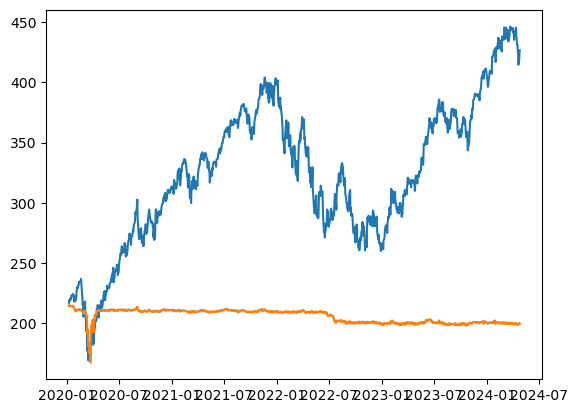

In [319]:
Y_pred_df = pd.DataFrame({'close':Y_pred}, index = Y_test.index)
plt.plot(Y_test)
plt.plot(Y_pred_df)

In [219]:
# X_train[pd.isnull(X_train).any(axis = 1)]
test = [qqq.columns[150:]]
# X_train[pd.isnull(X_train).any(axis = 1)]
count = np.isinf(qqq).values.sum() 
print(count)

3520


In [261]:
qqq.columns[20:40]

Index(['MACD', 'macd_signal', 'stoch_%K', 'stoch_%D', 'OBV', 'A/D', 'adx_DI+',
       'adx_DI-', 'ADX', 'aroon_up', 'aroon_down', 'bonds_time', 'bonds_open',
       'bonds_high', 'bonds_low', 'bonds_close', 'rsi_lvl', 'rsiMA_lvl',
       'prev_rsi', 'prev_rsiMA'],
      dtype='object')

In [263]:
def show_inf_values(df):
    for column in df.columns:
        inf_mask = np.isinf(df[column])
        if inf_mask.any():
            print(f"\nInfinite values in {column}:")
            print(df.loc[inf_mask, column])

# show_inf_values(qqq)

test = [276,278,279,337,338,339,580,581,582,1455,1456,1457,1665,1666,1667,1725,1753,1887]
# qqq.iloc[276:279]['roc_%K_1D']
test2 = ['roc_%K_1D', 'stoch_%K']
qqq[qqq.index.isin(test)][test2]

roc_%K_1D   stoch_%K
276   -0.393471  30.405405
278         inf   5.058366
279    2.250772  16.443595
337   -1.000000   0.000000
338         inf  47.783268
339    0.202062  57.438437
580   -1.000000   0.000000
581         inf   9.210362
582    2.196486  29.440789
1455  -1.000000   0.000000
1456        inf   4.477897
1457   2.784008  16.944397
1665  -1.000000   0.000000
1666        inf   3.096275
1667   7.074130  24.999728
1725        inf  32.554727
1753        inf  23.662761
1887        inf  11.636364

In [ ]:
qqq.to_csv('data/qqq_popular_feats.csv')

#### LightGBM

#### CatBoost

### Random Forest

### Regression

### Deep Learning

#### Deep Neural Network

#### Recurrent Neural Network (RNN) / Long Short Term Memory (LSTM)